# Variational Autoencoder
<u>Resources</u> <br>
Paper : [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)<br>
Intro to VAE paper: [Intro to VAE](https://arxiv.org/pdf/1906.02691.pdf)<br>

### Introduction
VAE is stochastoc variational inference and learning algorithm. Learning distribution rather than single point and is a genereative model unlike our regular deep autoencoders. 

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png"
     alt="VAE"
     style="float: left; margin-right: 5px;" />

<u> <b>Major contributions of the Paper</b></u>: 
1. Reparametization to optimize ELBO using Stoctic learning Algorithm
2. Posterior Inference made through approximated inference model(also called Rognition or encoder model)

<b><u>Background info</b></u>
1. <b>Probabilistic Model and VI</b>
\begin{aligned}
&\qquad \begin{array}{c}
x \text { be observed random sample from unknown underlying process, whose } \\
\text { true distribution is } P^{*}(x) \text { . We approximate undarlying Process with model } \\
P_{\theta}(x) \text { with parcimeter } \theta \text { . We learn } \theta \text { s.t } \\
P_{\theta}(x) \approx P^{*}(n)
\end{array}
\end{aligned}
2. <b>Learnng in Neural Network(Fully Observed variables) </b>
$$
\left.D=\{ x^{(1)}, \cdots, x^{(n)}\right\}=\left\{x^{i}\right]_{i=1}^{N}=x^{(1:N)}
$$
log Probabily of D given prameter $(\theta)$ is $ log P_{\theta}(D)=\sum_{n \in D} log P_{\theta}(x)$
where $\theta$ is random at first then we perform optinization using ML by
using SGD . Randomly draw minibatches $(M \subset D)$. Then find unbiased estimator of $\mathrm{ML}$ criteria
$$
\frac{1}{N_{D}} \log _{\theta}(D) \simeq \frac{1}{N_{m}} \log _{\theta}(m)
$$
Therefore,
$$
\frac{1}{N_{D}} \nabla_{\theta} \log P_{\theta}(D) \simeq \frac{1}{N_{m}} \nabla_{\theta} \log P_{\theta}(M)
$$

3. <b>Learning and Inference in Deep Latent Variable Model(DLVB)</b>
\begin{aligned}
&\text { Latent Variables are the unobserved variables that are not part of } \\
&\text { the Dataset but part of the model. Usally denoted by 'z'. } \\
&\text { For example let } z \text { be discrete }\left(z=\{1, \cdots, k \}) \text { and } P_{\theta}(x \mid z)\right. \text { be } \\
&\text { gaussian then } p_{\theta}(x)\text { a miature of garsion. }
\end{aligned}


\begin{aligned}
&\text { DLVM is a latent Variable model } P_{\theta}(x, z) \text { whose distribution } \\
&\text { is parametized by NN. Marginal Distribation } P_{\theta}(x) \text { can get complex } \\
&\text { and Suffers intractibility. Like in the mixture of gausian, } P(x \mid z=1) \\
&\text { and } P(x \mid z=2) \text { were Normal Distribution, However } P(X) \text { is a } \\
&\text { complex distribution. Also, the traditional traditional Approximation } \\
&\text { Techniques are expensive for such complex and Deep model. } \\
&\qquad P_{\theta}(x)=\int P_{\theta}(x, z) d z \text { , It doesn't have analytical Solution }
\end{aligned}

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import pandas as pd
import random
from tqdm import tqdm

Hyper Parameters

In [3]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

Load the MNIST dataset and create dataloader

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

##Getting training set
train_dataset = torchvision.datasets.MNIST(root="../PCA/data", train=True, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##Getting test set
test_dataset = torchvision.datasets.MNIST(root="../PCA/data", train=False, transform=transform, download=False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## Method
ML inference on Global Parameters and Variational Inference on Latent Variables. VAE efficiently optimizes DMLM using inference model with SGD. 

<b><u>Problem Setup</b></u>
\begin{aligned}
&\left.\operatorname{Dataset}(x)=\{ x^{(i)}\right\}_{i=1}^{N} \text { iid samples } \\
&\text { latent variable } z^{(i)} \\
&x^{(i)} \sim P_{\theta^{*}}(x \mid z) \text { and } z^{(i)} \sim P_{\theta^{*}}(z) \\
&P_{\theta}(x), P_{\theta}(z \mid x) \text { are intractable due to complex } \\
&\text { liklihood function. VAE poovides efficient } \\
&\text { ML estimation of parameter } \theta \text { , posterior inference } \\
&\text { of } z \text { given } x \text { for choice of } \theta \text { and approimation } \\
&\text { of marginal inference of } x \text { . }
\end{aligned}

<b><u>Encoder(Recognition Model)</b></u>
parametric inference model $q_{\phi}(z \mid x)$ is used to convert DLVM intractable inference and learning problem to tractable. We optimize variational parameters
$(\phi)$ s.t
$$
q_{\phi}(z \mid x) \approx P_{\theta}(z \mid x)
$$<br>
$\phi$ is weight and bias of our Neural Network
\begin{aligned}
(\boldsymbol{\mu}, \log \boldsymbol{\sigma}) &=\text { EncoderNeuralNet }_{\phi}(\mathbf{x}) \\
q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) &=\mathcal{N}(\mathbf{z} ; \boldsymbol{\mu}, \operatorname{diag}(\boldsymbol{\sigma}))
\end{aligned}
<b><u>Decoder(Generative Model)</b></u>

The decoder model $P_{\theta}(x \mid z)$ takes the sampled z and produces a distribution over the cooresponding values of x. 

The VAE can be viewed as two coupled, but independently parameterized models: the encoder or recognition model, and the decoder or
generative model. These two models support each other. The recognition model delivers to the generative model an approximation to its
posterior over latent random variables, which it needs to update its
parameters inside an iteration of “expectation maximization” learning.
Reversely, the generative model is a scaffolding of sorts for the recognition model to learn meaningful representations of the data, including
possibly class-labels. The recognition model is the approximate inverse
of the generative model according to Bayes rule.
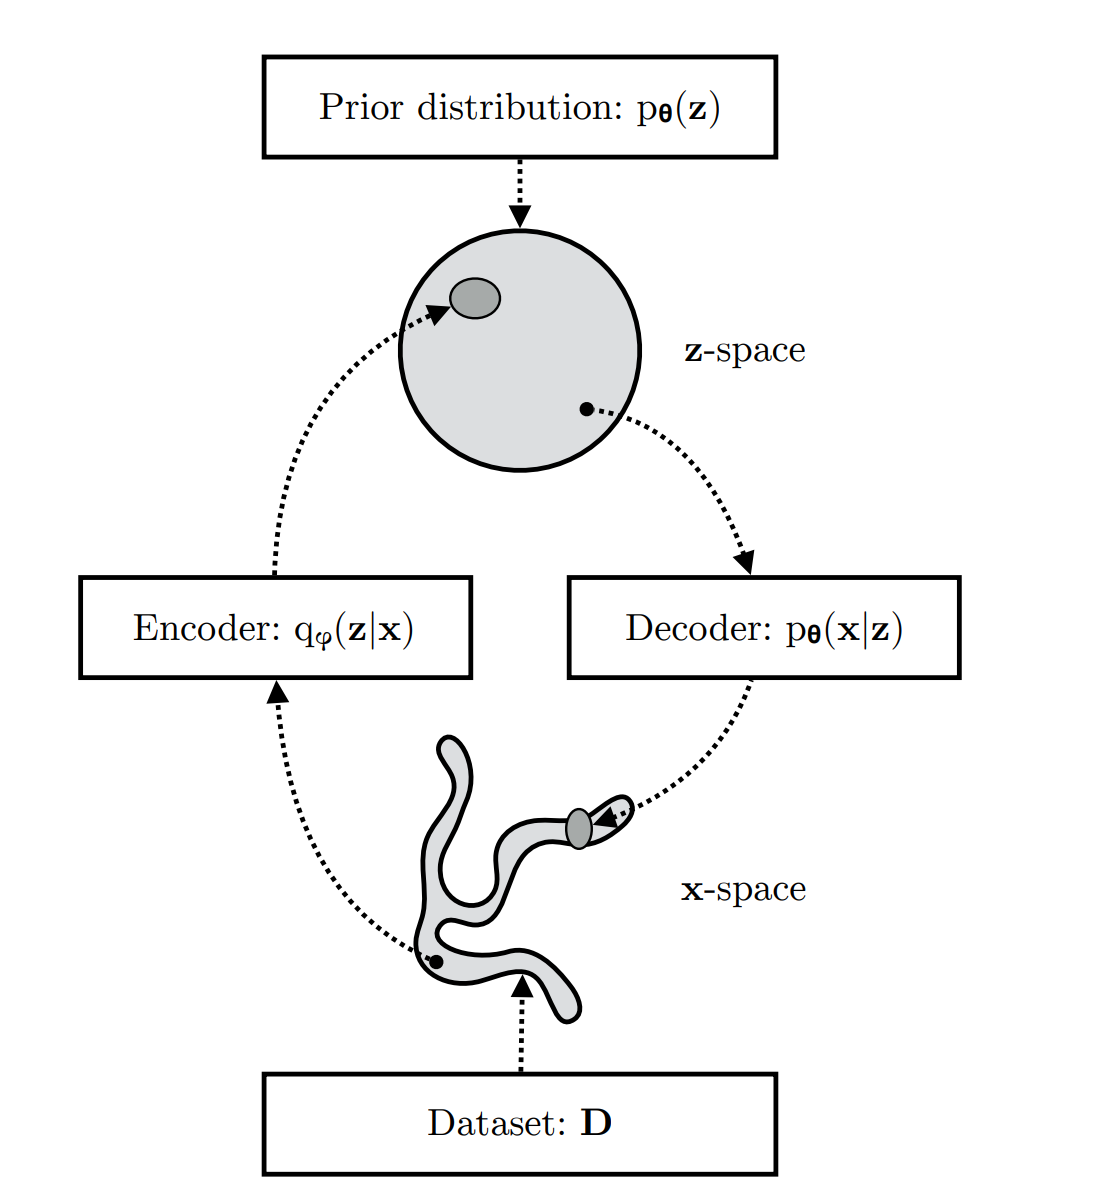

## Variational Bound
With some simplification(Alternatively using Jensen Inequlity, Usally jensen is used for variational methods)
$log p_{\theta}(x) =\underbrace{\mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\left[\log \left[\frac{p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})}{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\right]\right]}_{=\mathcal{L}_{\theta, \phi}(\mathbf{x}) \atop(\mathrm{ELBO})}+\underbrace{\mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\left[\log \left[\frac{q_{\phi}(\mathbf{z} \mid \mathbf{x})}{p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})}\right]\right]}_{=D_{K L}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \| p_{\theta}(\mathbf{z} \mid \mathbf{x})\right)}$

Since $D_{KL}$ is non-negative,<br>
$\log p_{\theta}(x) \geq ELBO =E_{q_{\phi}(z \mid x)}\left[\log \left(p_{\theta}\left(x,z\right)\right)-\log q_{\phi}(z \mid x)\right]$<br>
Hence, ELBO is lower bound of logliklihood of the data<br> 
So, maximizing ELBO implies maximizing the log liklihood of the data(better Generative Model) and minimizing the KL between true and approximate of the posterior(better inference model). 

## Optimization

We use Stochastic based optimization of ELBO where $\phi and \theta$ are jointly optimized. <br>
$\mathcal{L}_{\boldsymbol{\theta}, \phi}(\mathbf{x})=\mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})-\log q_{\phi}(\mathbf{z} \mid \mathbf{x})\right]$<br>
We optimize $\phi$ with $\theta$ random and then $\theta$ with our previous $\phi$ and we keep optimizing both jointly. 

$\{$<br>
$\theta:=\theta+\eta \nabla_{\theta} \alpha_{\theta}, \phi(x)$<br>
$\phi:=\phi+\eta \nabla_{0} \alpha \theta, \phi(x)$<br>
$\}$ repeat until convergence<br>
gradients with $\theta$ can be easily computed but for $\phi$ is difficult since ELBO's expectation is taken wrt distribution that is a function of $\phi$.So,we cannot put gradient inside of expectation. 

## Reparameterization Trick

Transform $z  \sim \operatorname{q}_{\phi}(z \mid x)$ as function of some orter randon variable $(\epsilon)$ that is differntiable and invertisle given $\phi$ ard $z$ <br>
(Using change of varible) $z=g(\epsilon, \Phi, x) \quad \epsilon $ is indpendent of $\phi$ and $\epsilon$.
so, Expectation can be eppresed as
$$
E_{q_{\phi}(z \mid x)}[f(z)]=E_{p(\epsilon)}[f(z)] \text { where, } z=g(\epsilon, \phi, x)
$$
Then,
$$
\begin{aligned}
\nabla_{\phi} E_{q_{\phi}(z \mid x)}[f z]=& \nabla_{d} E_{p(\epsilon)}[f(z)] \\
&=E_{p(\epsilon)}\left[\nabla_{\phi} f(z)\right]
\end{aligned}
$$<br>
where, $\epsilon \sim$ p($\epsilon$)

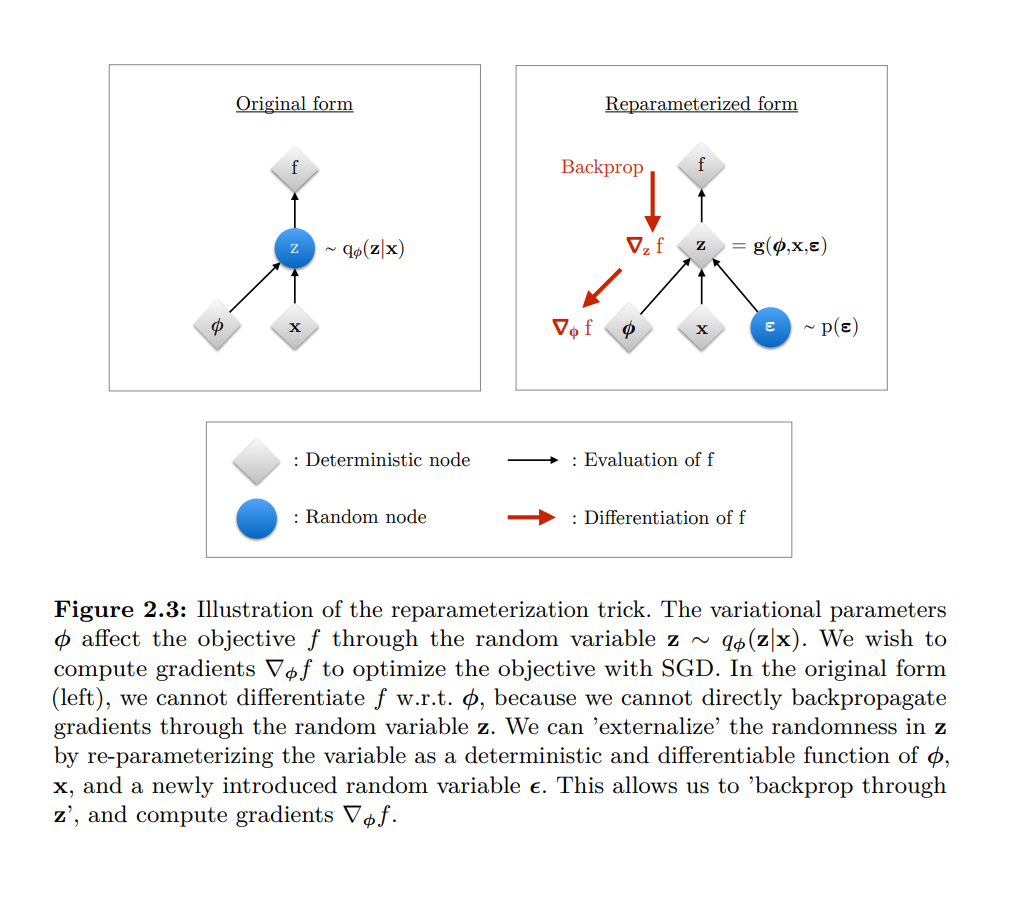

## Some implementation Details

<b>Gaussian MLP as Encoder:</b>
In this case our encoder is factorized multivariate Gaussian given by,
\begin{aligned}
(\boldsymbol{\mu}, \log \boldsymbol{\sigma}) &=\text { EncoderNeuralNet }_{\phi}(\mathbf{x}) \\
q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) &=\mathcal{N}(\mathbf{z} ; \boldsymbol{\mu}, \operatorname{diag}(\boldsymbol{\sigma}))
\end{aligned}

$$
\begin{aligned}
\text { where } \boldsymbol{\mu} &=\mathbf{W}_{4} \mathbf{h}+\mathbf{b}_{4} \\
\log \boldsymbol{\sigma}^{2} &=\mathbf{W}_{5} \mathbf{h}+\mathbf{b}_{5} \\
\end{aligned}
$$


<b>Bernoulli MLP as decoder</b>
In this case let $p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z})$ be a multivariate Bernoulli whose probabilities are computed from $\mathbf{z}$ with a fully-connected neural network :
$$
\begin{gathered}
\log p(\mathbf{x} \mid \mathbf{z})=\sum_{i=1}^{D} x_{i} \log y_{i}+\left(1-x_{i}\right) \cdot \log \left(1-y_{i}\right) \\
\text { where } \mathbf{y}=f_{\sigma}\left(\mathbf{W}_{4} \tanh \left(\mathbf{W}_{3} \mathbf{z}+\mathbf{b}_{3}\right)+\mathbf{b}_{4}\right)
\end{gathered}
$$
where $f_{\sigma}(.)$ is the elementwise sigmoid activation function.

<b>Gaussian MLP as Decoder</b> Same as encoder but produces x given z 

Prior Over latent variable is isotropic Gausion,<br>
$P_{\theta}(z)=\mathcal{N}(z ; 0,I)$
$P_{\theta}(x \mid z)$ is Decoder(Bernoulli or Gaussion) <br>



Approximate true postorior $\left(P_{\theta}(z \mid x)\right.$ by $q_{\phi}(z \mid x)$ which we assume to be multivariate Gaussian with diagonal Co-varianve
$\log q_{\phi}\left(z \mid x^{(i)}\right)=\log N\left(z ; \mu^{(i)}, \sigma^{2}(I)\right)$<br>
where, $\mu^{i}$ and $\sigma^{2}$ (i) are outputs of an encoder. $z^{(i)} \sim q_{\phi}\left(z \mid x^{(i)}\right)$. Using reparameforization trick we change the variable s.t <br>
$z=g_{\phi}\left(x^{(i)}, E\right)=u^{(i)}+\sigma^{(i)} \odot e$<br>
Now loss function is:<br>
$\mathcal{L}\left(\boldsymbol{\theta}, \boldsymbol{\phi} ; \mathbf{x}^{(i)}\right)=-D_{K L}\left(q_{\boldsymbol{\phi}}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right) \| p_{\boldsymbol{\theta}}(\mathbf{z})\right)+\mathbb{E}_{q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}\right)\right]$
$=-D_{KL}\left(N\left(\mu, \sigma^{2} I\right) \| N(0, I)\right)$$+\mathbb{E}_{p_{\epsilon}(x)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}\right)\right]$

Therefore Loss is given by(Using montecarlo estimation($D_{KL}$ is solved analytically),
\begin{aligned}
&\mathcal{L}\left(\boldsymbol{\theta}, \boldsymbol{\phi} ; \mathbf{x}^{(i)}\right) \simeq \frac{1}{2} \sum_{j=1}^{J}\left(1+\log \left(\left(\sigma_{j}^{(i)}\right)^{2}\right)-\left(\mu_{j}^{(i)}\right)^{2}-\left(\sigma_{j}^{(i)}\right)^{2}\right)+\frac{1}{L} \sum_{l=1}^{L} \log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}^{(i, l)}\right)\\
&\text { where } \mathbf{z}^{(i, l)}=\boldsymbol{\mu}^{(i)}+\boldsymbol{\sigma}^{(i)} \odot \boldsymbol{\epsilon}^{(l)} \quad \text { and } \quad \boldsymbol{\epsilon}^{(l)} \sim \mathcal{N}(0, \mathbf{I})
\end{aligned}



In [20]:
latent_vector = 2
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=64)
        self.enc3 = nn.Linear(in_features=64, out_features=8)
        
        #Get mu and var =>  (mu,logvar) = NN(x)
        self.enc_mu = nn.Linear(in_features=8, out_features=latent_vector)
        self.enc_log_var = nn.Linear(in_features=8, out_features=latent_vector)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=latent_vector, out_features=8)
        self.dec2 = nn.Linear(in_features=8, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=256)
        self.dec4 = nn.Linear(in_features=256, out_features=784)
        
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # e(log(sqrt(var))) = std
        eps = torch.randn_like(std) # get samples from N(0,1) with same shape as Std
        sample = mu + (eps * std) # change of variable z~N(mu,var) to z=mu+eps*std with e~N(0,1) where,
                                # mu and log_var are the output of the encoder
        return sample
 
    def forward(self, x, encode = True):
        if encode:
            x = torch.relu(self.enc1(x))
            x = torch.relu(self.enc2(x))
            x = torch.relu(self.enc3(x))
            mu = self.enc_mu(x)
            log_var = self.enc_log_var(x)     
        else:
            #if only decoding needs to be done, then x is given as a list [mu, logvar]
            mu = x[0]
            log_var = x[1]
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)#sample z from q(z|x) to feed into decoder
 
        # decoding
        x = torch.relu(self.dec1(z))
        x = torch.relu(self.dec2(x))
        x = torch.relu(self.dec3(x))
        #reconstruction = torch.Tanh(self.dec4(x)) # for gaussian decoder
        reconstruction = torch.sigmoid(self.dec4(x))# for bernoulli decoder
        return reconstruction, mu, log_var

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')# for bernoulli decoder, log liklihood of data of bernoulli simplifies to BCE
#criterion = nn.MSELoss() # for gaussian decoder, log liklihood of data of gaussian simplifies to MSE

\begin{aligned}
&\mathcal{L}\left(\boldsymbol{\theta}, \boldsymbol{\phi} ; \mathbf{x}^{(i)}\right) \simeq \frac{1}{2} \sum_{j=1}^{J}\left(1+\log \left(\left(\sigma_{j}^{(i)}\right)^{2}\right)-\left(\mu_{j}^{(i)}\right)^{2}-\left(\sigma_{j}^{(i)}\right)^{2}\right)+\frac{1}{L} \sum_{l=1}^{L} \log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}^{(i, l)}\right)\\
&\text { where } \mathbf{z}^{(i, l)}=\boldsymbol{\mu}^{(i)}+\boldsymbol{\sigma}^{(i)} \odot \boldsymbol{\epsilon}^{(l)} \quad \text { and } \quad \boldsymbol{\epsilon}^{(l)} \sim \mathcal{N}(0, \mathbf{I})
\end{aligned}

In [22]:
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss # MSE for gausian and hyperparam the weight of two loss(second Term of loss function)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #(first term of the loss function)
    return BCE + KLD

In [23]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [24]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [25]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20
Train Loss: 257.6278
Val Loss: 197.5158
Epoch 2 of 20
Train Loss: 192.0645
Val Loss: 188.3997
Epoch 3 of 20
Train Loss: 187.0469
Val Loss: 183.9130
Epoch 4 of 20
Train Loss: 177.8627
Val Loss: 173.5730
Epoch 5 of 20
Train Loss: 170.5178
Val Loss: 168.8961
Epoch 6 of 20
Train Loss: 166.9354
Val Loss: 166.3262
Epoch 7 of 20
Train Loss: 165.1605
Val Loss: 164.8046
Epoch 8 of 20
Train Loss: 163.7448
Val Loss: 163.4166
Epoch 9 of 20
Train Loss: 162.2570
Val Loss: 162.0961
Epoch 10 of 20
Train Loss: 160.6864
Val Loss: 160.3131
Epoch 11 of 20
Train Loss: 159.0552
Val Loss: 159.1376
Epoch 12 of 20
Train Loss: 157.9280
Val Loss: 157.8401
Epoch 13 of 20
Train Loss: 156.9216
Val Loss: 156.6902
Epoch 14 of 20
Train Loss: 156.1091
Val Loss: 157.2216
Epoch 15 of 20
Train Loss: 155.3774
Val Loss: 156.8017
Epoch 16 of 20
Train Loss: 154.6848
Val Loss: 155.0672
Epoch 17 of 20
Train Loss: 153.8943
Val Loss: 154.3865
Epoch 18 of 20
Train Loss: 153.2346
Val Loss: 153.6420
Epoch 19 of 20
Trai

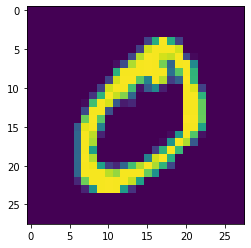

In [56]:
plt.imshow(train_dataset[1][0].reshape(28,28))

In [57]:
recons=model.forward(train_dataset[1][0].reshape(1,784))[0]

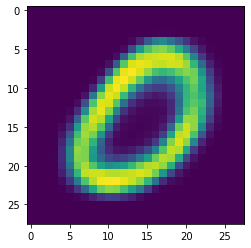

In [58]:
plt.imshow(recons.detach().numpy().reshape(28,28))

In [64]:
def plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.randn(2,2).to(device)
            x_hat = autoencoder.forward(z,encode=False)[0]
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

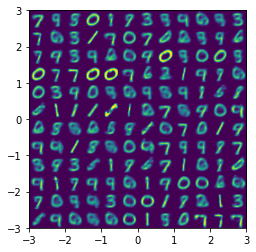

In [65]:
plot_reconstructed(model)

In [79]:
def reparameterize(mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # e(log(sqrt(var))) = std
        eps = torch.randn_like(std) # get samples from N(0,1) with same shape as Std
        sample = mu + (eps * std) # change of variable z~N(mu,var) to z=mu+eps*std with e~N(0,1)
        return sample

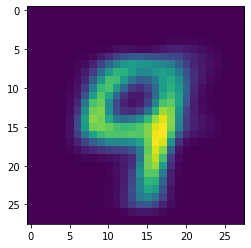

In [59]:
mu = torch.tensor(np.zeros((1, latent_vector))).float()
logvar = torch.tensor(np.ones((1, latent_vector))).float()
representation = [mu, logvar]
with torch.no_grad():
    reconstruction,_, _ = model.forward(representation, encode=False)
    plt.imshow(reconstruction.numpy().reshape(28, 28))